In [1]:
import sys, os
my_path = os.path.abspath('')
sys.path.insert(0, my_path + '/../')

import numpy as np
import matplotlib.pyplot as plt
import FLife
import copy
from IPython.display import clear_output
from matplotlib import rcParams
import math 
from scipy import signal
import matplotlib

In [2]:
#set font for figures

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "20"
plt.rcParams["mathtext.fontset"] = "dejavuserif" # mathmode

# Simulated spectra

 The proposed spectra are arranged into the categories: spectral width (SW), background noise (BN), close mode spectra (CM), multi-mode spectra (MM) and typical automotive spectra (AM). To further investigate the applicability of spectral methods for fatigue analysis of bimodal Gaussian process, a bimodal spectra (BM) category is used.

In [3]:
f_min, f_max = 10, 1000 # [Hz], frequency range 10-1000 Hz is used for all spectra 
f = np.arange(0, f_max+1, 1)# frequency vector
RMS = 10 # [MPa] 

spectra = {} # dictionary for spectra definition

## Spectral width (SW)

With the central frequency of 450 Hz and  $\epsilon_\mathrm{V} \!=\! 0.05$, the initial narrowband random process expands in both directions during each iteration. In each iteration the Vanmarcke parameter of random process increases by 0.05.

In [4]:
spectra['SW'] = {}  # Spectral width category (SW)

f_central = 450 # [Hz]
width_factor_list = [0.0868, 0.175, 0.263, 0.354, 0.448, 0.546, 0.648, 0.756, 0.873]  #predefined values to achieve desired vanmarcke's parameters
delta_f_list = [f_central * width_factor for width_factor in width_factor_list] # [Hz], spectral width is 2*delta_f 

for delta_f in delta_f_list:
    f_lower = f_central - delta_f
    f_upper = f_central + delta_f
    
    PSD = np.interp(f, [f_lower, f_upper], [1, 1], left=0, right=0) 
    PSD = PSD / np.trapz(PSD,f) * RMS**2  # RMS of all processes is the same
    
    sd = FLife.SpectralData(input=(PSD, f))
    vanmarcke = sd.get_vanmarcke_parameter(sd.PSD_splitting) # get vanmarcke's parameter
    
    spectra['SW'][f'vanmarcke={vanmarcke[0]:.2f}'] = [PSD, f]

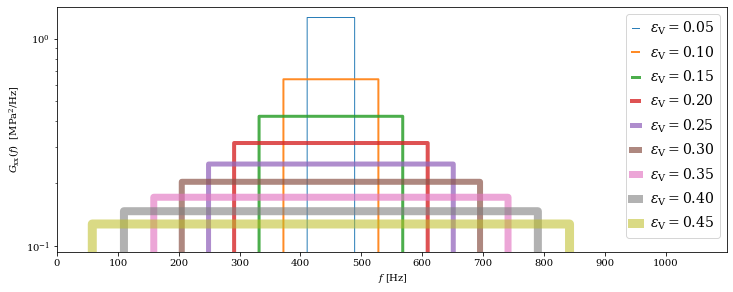

In [5]:
plt.figure(figsize=(12,4.5))

for indx, (PSD_key, PSD_value) in enumerate(spectra['SW'].items()):
    vanmarcke = float(PSD_key.split('=')[1])
    plt.semilogy(PSD_value[1], PSD_value[0], alpha = 1 - (indx+1)*0.05, lw = 1+indx, label =r'$\epsilon_\mathrm{V}' + 
             f'= {vanmarcke:.2f}$')
    
plt.xlim(0,1100)
plt.xticks(np.arange(0, 1100, 100))

ax = plt.gca()
y_min, y_max = ax.get_ylim()
y_min = math.floor(y_min*100)/100
ax.set_ylim(y_min*.85, y_max)

plt.legend(handlelength=0.5, loc = 'upper right', fontsize=14)
plt.xlabel(' $f\,\,[\mathrm{Hz}]$')
plt.ylabel('$G_\mathrm{xx}(f)$  [$\mathrm{MPa}^2/\mathrm{Hz}$]');
#plt.savefig('spectra_bandwidth.pdf', bbox_inches='tight');

## Background noise (BN)

The initial process is considered narrowband with the central frequency of 450 Hz and Vanmarcke parameter $\epsilon_\mathrm{V} \!=\! 0.05$. In each iteration the amplitude of the background noise in the frequency-range $\left[10 \,\mathrm{Hz}, 900 \,\mathrm{Hz}\right]$ is increased, such as the Vanmarcke parameter of random process increases by 0.05.

In [6]:
spectra['BN'] = {} # Background noise category (BN)

f_central = 450 # [Hz]
width_factor = 0.088 
delta_f = f_central * width_factor # [Hz], predefined value to obtain vanmarcke's parameter 0.05
f_lower = f_central - delta_f
f_upper = f_central + delta_f
f_max_BN = 900 # maximal frequency for BN category

noise_amplitude_list = [0, 0.0021, 0.006, 0.012, 0.0218, 0.0365, 0.063, 0.115, 0.25] #predefined amplitudes to achieve desired vanmarcke's parameters

for noise_amplitude in noise_amplitude_list:
    amplitude_data = [noise_amplitude, noise_amplitude, 1, 1, noise_amplitude, noise_amplitude]
    PSD = np.interp(f, [f_min, f_lower, f_lower, f_upper, f_upper, f_max_BN], amplitude_data, left=0, right=0) 
    PSD = PSD / np.trapz(PSD,f) * RMS**2
    
    sd = FLife.SpectralData((PSD, f))
    vanmarcke = sd.get_vanmarcke_parameter(sd.PSD_splitting)
    spectra['BN'][f'vanmarcke={vanmarcke[0]:.2f}'] = [PSD, f]

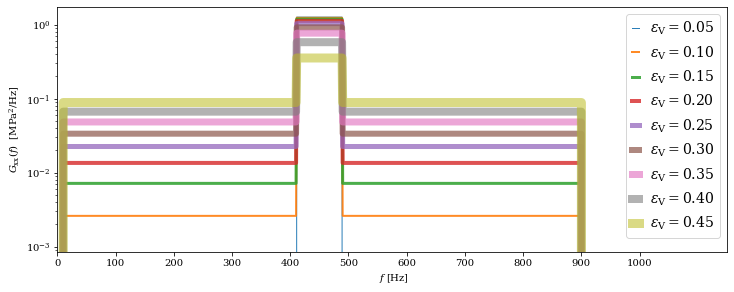

In [7]:
plt.figure(figsize=(12,4.5))

for indx, (PSD_key, PSD_value) in enumerate(spectra['BN'].items()):
    vanmarcke = float(PSD_key.split('=')[1])
    #print(vanmarkov_parameter)
    plt.semilogy(PSD_value[1], PSD_value[0], alpha = 1 - (indx+1)*0.05, lw = 1+indx, label = r'$\epsilon_\mathrm{V}' + 
             f'= {vanmarcke:.2f}$')
    
plt.xlim(0,1150)
plt.xticks(np.arange(0, 1100, 100))

ax = plt.gca()
y_min, y_max = ax.get_ylim()
y_min = math.floor(y_min*1000)/1000
ax.set_ylim(y_min*.85, y_max)

plt.legend(handlelength=0.5, loc = 'upper right', fontsize=14)
plt.xlabel(' $f\,\, [\mathrm{Hz}]$')
plt.ylabel('$G_\mathrm{xx}(f)$  [$\mathrm{MPa}^2/\mathrm{Hz}$]');
#plt.savefig('spectra_background_noise.pdf', bbox_inches='tight');

## Close-mode spectra (CM)

Two rectangular blocks with a Vanmarcke parameter $\epsilon_\mathrm{V} \!=\! 0.05$ and central frequencies of 100 and 800 Hz are at each iteration step moved closer for 100 Hz.

In [8]:
def bimodal_spectrum(f, f_LF, f_HF, beta, width_factor=0.088, RMS=1):
    '''
    Bimodal PSD, characterized by low-frequency (LF) and high-frequency (HF)
    component of random process. Ratio of components variance is determined by parameter 
    `beta`. Width of each component is determined by width factor (2 * width_factor * f_central). 
    Modes have equal Vanmarcke's parameter.
    
    :param f: Frequency vector
    :type f: numpy.ndarray
    :param f_LF: Central frequency of LF component
    :type f_LF: int, float
    :param f_HF: Central frequency of HF component
    :type f_HF: int, float
    :param beta: HF and LF component variance ratio
    :type beta: int, float
    :param width_factor: Width factor. Defaults to 0.088, which set Vanmarcke's parameter of each block to 0.05
    :type width_factor: int, float
    :param RMS: RMS of returned PSD
    :type RMS: int, float
    :returns: PSD
    '''
    # frequency and area ratio
    if f_HF/f_LF >= 1 and beta > 0:
        
        #low-frequency component
        delta_f_LF = f_LF * width_factor # half width
        var_LF = 1
        amplitude_LF = var_LF / (2 * delta_f_LF) 
        f_lb_LF = f_LF - delta_f_LF # lower boundary of LF component
        f_ub_LF = f_LF + delta_f_LF # upper boundary of LF component
        
        #high-frequency component
        delta_f_HF = f_HF * width_factor # half width
        var_HF = beta * var_LF
        amplitude_HF = var_HF / (2 * delta_f_HF)
        f_lb_HF = f_HF - delta_f_HF # lower boundary of HF component
        f_ub_HF = f_HF + delta_f_HF # upper boundary of FF component
        
        #PSD
        PSD = np.interp(f, [f_lb_LF,f_ub_LF,f_ub_LF, f_lb_HF,f_lb_HF,f_ub_HF],
                        [amplitude_LF,amplitude_LF,0, 0,amplitude_HF,amplitude_HF], left=0, right=0)
        PSD = PSD/np.trapz(PSD,f) * RMS**2
    
        return PSD
    
    else:
        return None

In [9]:
spectra['CM'] = {} # Close modes category (CM)

f_LF = 100 # [Hz], central frequency of LF component
f_HF = 800 # [Hz], central frequency of HF component
step = 50 # [Hz], step for each blosk is 50 Hz

f_central_list = [] # list of central frequencies in each iteration
while True:
    f_central_list.append([f_LF, f_HF])
    f_LF += step
    f_HF -= step
    if f_HF <= f_LF:
        break
    
beta = 1 # both components have same variance
width_factor = 0.088 # both components are narroband
for f_LF, f_HF in f_central_list:
    PSD = bimodal_spectrum(f, f_LF=f_LF, f_HF=f_HF, beta=beta, width_factor=width_factor, RMS=RMS)
    spectra['CM']['f_LF,f_H=' + f'{f_LF:g}' + ',' + f'{f_HF:g}' + ' Hz'] = [PSD, f]

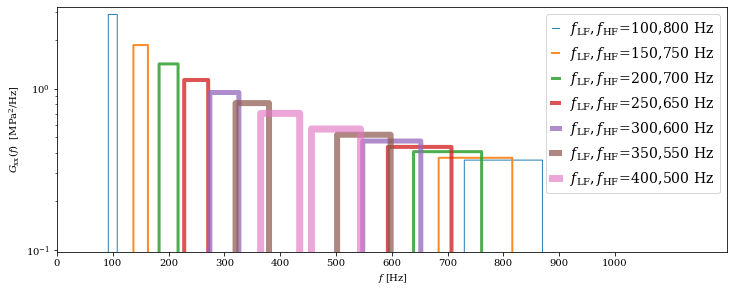

In [10]:
plt.figure(figsize=(12,4.5))

for indx, ((f_LF, f_HF),(PSD_key, PSD_value)) in enumerate(zip(f_central_list, spectra['CM'].items())):
    plt.semilogy(PSD_value[1], PSD_value[0],  alpha = 1 - (indx+1)*0.05, lw = 1+indx, label = r'$f_\mathrm{LF},f_\mathrm{HF}\!=\!$' + 
             f'${f_LF:.0f},\!{f_HF:.0f}$ Hz' )
    
plt.xlim(0,1200)
plt.xticks(np.arange(0, 1100, 100))

ax = plt.gca()
y_min, y_max = ax.get_ylim()
y_min = math.floor(y_min*1000)/1000
ax.set_ylim(y_min*.3, y_max)

plt.legend(handlelength=0.5, loc = 'upper right', fontsize=14)
plt.xlabel(' $f\,\, [\mathrm{Hz}]$')
plt.ylabel('$G_\mathrm{xx}(f)$  [$\mathrm{MPa}^2/\mathrm{Hz}$]');
#plt.savefig('spectra_close_mode.pdf', bbox_inches='tight');

##  Multimode spectra (MM)

Initial spectra has 3 dominant modes and with each subsequent iteration one additional mode is added (up to a maximum 6). The modes are positioned at the central frequencies of 100, 250, 400, 550, 700 and 850 Hz with amplitudes of 1 $\mathrm{MPa^2/Hz}$ and Vanmarcke parameter of each mode being $\epsilon_\mathrm{V} \!=\! 0.05$. 


In [11]:
def multimode_spectrum(f, f_central_list, width_factor=0.088, RMS=1):
    '''Modes have equal variance and equal Vanmarcke's parameter
    
    :param f: Frequency vector
    :type f: numpy.ndarray
    :param f_central_list: List of central frequencies of all modes.
    :type f_central_list: list
    :param width_factor: Width factor. Defaults to 0.088, which set Vanmarcke's parameter of each block to 0.05
    :type width_factor: int, float
    :param RMS: RMS of returned PSD. Defaults to 1.
    :type RMS: int, float
    :returns: PSD
    '''
    #1) Prepare frequency data
    width_factor = width_factor 
    f_data = [(f_central_i*(1 - width_factor),f_central_i*(1 - width_factor), f_central_i*(1 + width_factor),
               f_central_i*(1 + width_factor)) for f_central_i in f_central_list]
    f_data = [item for sublist in f_data for item in sublist] # data points on same level
    
    
    #2) 
    var_i = RMS**2 / len(f_central_list) # modes have equal variance
    amplitude_data = [var_i / (f_central_i*(1 + width_factor) - f_central_i*(1 - width_factor)) for f_central_i in f_central_list]
    amplitude_data = [(0,amplitude,amplitude,0) for amplitude in amplitude_data]
    amplitude_data = [item for sublist in amplitude_data for item in sublist] # data points on same level
    
    PSD = np.interp(f, f_data, amplitude_data, left=0, right=0) 
    
    return PSD

In [12]:
spectra['MM'] = {} # Multimode spectra category (MM)

f_central_list = np.arange(100, 900, 150) 
width_factor = 0.088 # components are narroband

for mode_nmbr in range(3,len(f_central_list)+1):
    PSD = multimode_spectrum(f, f_central_list[:mode_nmbr], width_factor=width_factor, RMS=RMS)
    spectra['MM']['N=' + str(mode_nmbr)] = [PSD, f]

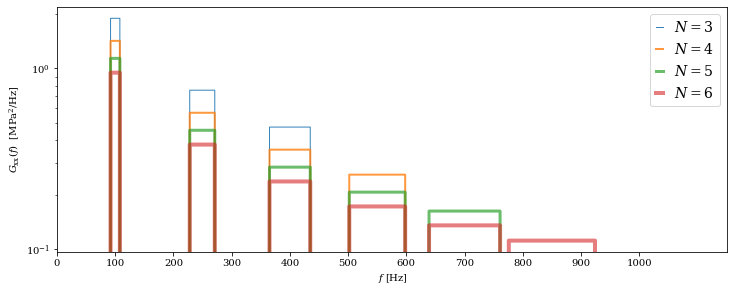

In [13]:
plt.figure(figsize=(12,4.5))

for indx, (PSD_key, PSD_value) in enumerate(spectra['MM'].items()):
    plt.semilogy(PSD_value[1], PSD_value[0], alpha = 1 - (indx+1)*0.1, lw = 1+indx, label = f'$N = {indx+3:g}$')
    
plt.xlim(0,1150)
plt.xticks(np.arange(0, 1100, 100))

ax = plt.gca()
y_min, y_max = ax.get_ylim()
y_min = math.floor(y_min*10000)/10000
ax.set_ylim(y_min*1, y_max)

plt.legend(handlelength=.5, loc = 'upper right', fontsize=14)
plt.xlabel(' $f\,\, [\mathrm{Hz}]$')
plt.ylabel('$G_\mathrm{xx}(f)$  [$\mathrm{MPa}^2/\mathrm{Hz}$]');
#plt.savefig('spectra_multimode.pdf', bbox_inches='tight');

## Automotive spectra (AM)

Three realistic industry spectra that are typical for the automotive industry are used in this category. Data used is from research by Mršnik et al. (Matjaž Mršnik, Janko Slavič, Miha Boltežar,
Frequency-domain methods for a vibration-fatigue-life estimation – Application to real data,
International Journal of Fatigue,
Volume 47,
2013,
Pages 8-17)

In [14]:
spectra['AM'] = {} # Automotive spectra category (AM)

nr_of_spectra = 3 # 3 different spectra

for indx in range(nr_of_spectra):
    data = np.load(os.path.join('m{}.npy'.format(indx+1, )))
    t_AM = data[::2][: int(3e6 + 1)] # time , 300 s
    x = data[1::2][: int(3e6 + 1)] # time_history
    
    dt_AM = t_AM[1] - t_AM[0]
    fs_AM = 1/dt_AM

    f_AM, PSD = signal.welch(x, fs_AM, nperseg=1280)
    f_indx = np.where(f_AM<=1000) # Frequency range 10-1000 Hz
    f_AM = f_AM[f_indx]
    PSD = PSD[f_indx]
    PSD = PSD / np.trapz(PSD, f_AM) * RMS **2

    spectra['AM'][str(indx)] = [PSD, f_AM]

0.0005640790227289716


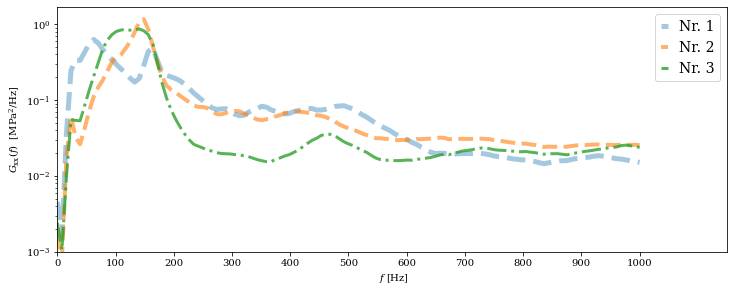

In [15]:
lines = ['--', '--', '-.']

plt.figure(figsize=(12,4.5))

for indx, (PSD_key, PSD_value) in enumerate(spectra['AM'].items()):
    plt.semilogy(PSD_value[1], PSD_value[0], lines[indx],  alpha = (indx+2)*0.2, lw = 5- indx, label = f'Nr. {indx+1:g}')
plt.xlim(0,1150)
plt.xticks(np.arange(0, 1100, 100))

ax = plt.gca()
y_min, y_max = ax.get_ylim()
print(y_min)
y_min = math.floor(y_min*10000)/10000
ax.set_ylim(1e-3, y_max)

plt.legend(handlelength=.5, loc = 'upper right', fontsize=14)
plt.xlabel(' $f\,\, [\mathrm{Hz}]$')
plt.ylabel('$G_\mathrm{xx}(f)$  [$\mathrm{MPa}^2/\mathrm{Hz}$]');
#plt.savefig('spectra_automotive.pdf', bbox_inches='tight');

## Bimodal spectra (BM)

A bimodal spectra category is defined, where a bimodal spectrum is formed by superposition of two rectangular blocks. The width of each block is adjusted such that the Vanmarcke parameter is $\epsilon_\mathrm{V} \!=\! 0.05$, ensuring that both components are practically narrowband. These two-block spectra are characterized by the frequency ratio $\gamma$ and the area ratio $\beta$

In [16]:
f_LF = 50 # central freqeuncy of LF component

# central frequency ratio
gamma_list = [1.5, 2, 2.5, 3, 4, 7, 10, 15]

# area ratio: var_LF + var_HF = 1
var_LF_list = np.arange(0.1, 1, .1)

beta_list = [(1-var_LF)/var_LF for var_LF in var_LF_list]

In [17]:
spectra['BM'] = {} # Bimodal spectra category (BM)

width_factor=0.088 # narrowband components
for gamma in gamma_list:
    
    f_HF = gamma * f_LF # central frequency of HF component
    
    for var_LF in var_LF_list:
        beta = (1-var_LF)/var_LF # var_LF + var_HF = 1
        
        PSD = bimodal_spectrum(f, f_LF=f_LF, f_HF=f_HF, beta=beta, width_factor=width_factor, RMS=RMS)
        spectra['BM']['gamma= ' + f'{gamma:g}' + ' ,var_LF=' + f'{var_LF:.1f}'] = [PSD, f]

## Vanmarcke's parameter range for individual spectra categories

In [18]:
for group in spectra.keys():
    spectra_vanmarcke_parameter = []
    
    for PSD_key, PSD_value in spectra[group].items():
        PSD = PSD_value[0]
        freq = PSD_value[1]
        
        sd = FLife.SpectralData((PSD,freq))
        vanmarcke = sd.get_vanmarcke_parameter(sd.PSD_splitting)
        spectra_vanmarcke_parameter.append(vanmarcke)
        
    vanmarcke_min, vanmarcke_max = np.min(spectra_vanmarcke_parameter), np.max(spectra_vanmarcke_parameter)
    print(f'Spectra: {group:s}, range: {vanmarcke_min:.2f} -  {vanmarcke_max:.2f}')

Spectra: SW, range: 0.05 -  0.45
Spectra: BN, range: 0.05 -  0.45
Spectra: CM, range: 0.12 -  0.61
Spectra: MM, range: 0.44 -  0.47
Spectra: AM, range: 0.65 -  0.71
Spectra: BM, range: 0.12 -  0.87


# Reference criteria - time-domain analysis

Due to large computation time and resources used the code for stability of fatigue-life estimate is not executed in this notebook.

In [19]:
'''
# Set data for time-domain analysis

fs = 10 * f_max # Sampling frequency
block_size = 20  # number of time-histories to form one block
''';

In [20]:
'''
spectra_RFC_T = dict() #dict for selected RP to be checked appropriate length T
spectra_RFC_T['PSD'] = {} # dict for PSD definition
spectra_RFC_T['cycles'] = {} # dict for extracted cycles
spectra_RFC_T['life'] = {} # dict for life results

# select some spectra from already defined ones; from each group 1 spectrum
spectra_RFC_T['PSD']['SW: vanmarcke=0.05'] = spectra['SW']['vanmarcke=0.05']  # Narrowband
spectra_RFC_T['PSD']['SW: vanmarcke=0.45'] = spectra['SW']['vanmarcke=0.45']  # Broadband, second spectrum from SW group
spectra_RFC_T['PSD']['BN: vanmarcke=0.25'] = spectra['BN']['vanmarcke=0.25'] # Background noise
spectra_RFC_T['PSD']['CM: f_LF,f_H=250,650 Hz'] = spectra['CM']['f_LF,f_H=250,650 Hz'] # Close modes
spectra_RFC_T['PSD']['MM: N=4'] = spectra['MM']['N=4'] # Multimode
spectra_RFC_T['PSD']['AM: Nr. 0'] = spectra['AM']['0'] # Automotive
spectra_RFC_T['PSD']['BM: gamma= 1.5 ,var_LF=0.1'] = spectra['BM']['gamma= 1.5 ,var_LF=0.3'] # Bimodal
''';

In [21]:
'''
T_ref = 3600
T_list = np.logspace(0,np.log2(T_ref), base=2)

# 1) random process
for spectrum_key in spectra_RFC_T['PSD'].keys():
    
    spectra_RFC_T['cycles'][spectrum_key] = {} # use same keys for extracted cycles as for PSD definition
    
    # 2) length
    for T in T_list:        
        cycles_tmp = []
        seed = 1234

        # 3) RP indx
        for indx in range(block_size):
            
            seed += 1
            print(f'PSD={spectrum_key:s}, T={T:g}, RP={indx+1:g}')
            
            PSD, f = spectra_RFC_T['PSD'][spectrum_key]

            rg =  np.random.default_rng(seed)
            sd = FLife.SpectralData(input=(PSD,f), T=float(T), fs=float(fs), rg=rg) # time history is generated at SpectralData instantiation
            rf = FLife.Rainflow(sd)
            cycles_tmp.append(rf._get_cycles(algorithm = 'three-point'))

        spectra_RFC_T['cycles'][spectrum_key][T] = cycles_tmp
    clear_output()
''';

In [22]:
'''
# Material parameters
materials = {}
materials['steel'] = [1.934e12, 3.324] # [C, k]
materials['aluminium'] = [6.853e19, 7.3]
materials['spring steel'] = [1.413e37, 11.76]
''';

In [23]:
'''
# get life estimate based on exctracted cycles

# 1) random process
for process in spectra_RFC_T['cycles'].keys():

    spectra_RFC_T['life'][process] = {}
    
    # 2) material 
    for material_key, material_value in materials.items():
    
        spectra_RFC_T['life'][process][material_key] = {}
            
        C = material_value[0] # S-N slope parameters
        k = material_value[1]

        # 3) # random process length
        for T_i, cycles in spectra_RFC_T['cycles'][process].items(): 

            damage = []

            # Random process instances
            for cycles_j in cycles: 
                ranges = cycles_j[0]
                counts = cycles_j[2]
                d = np.sum(counts * (0.5*ranges)**k / C)
                damage.append(d)


            spectra_RFC_T['life'][process][material_key][T_i] = (T_i/np.mean(damage)) # Average fatigue life
''';

In [24]:
'''
# get cycle and half-cycle count
spectra_RFC_T['counts'] = {}

for process in spectra_RFC_T['cycles'].keys():

    spectra_RFC_T['counts'][process] = {}

    for T_i, cycles in spectra_RFC_T['cycles'][process].items():

        counts = []
        for indx, cycles_i in enumerate(cycles):
            counts.append(cycles_i[2])

        counts = np.array([item for sublist in counts for item in sublist])
        spectra_RFC_T['counts'][process][T_i] = counts/(indx+1)
''';

In [25]:
'''
# relative error, reference is fatigue life at 3600 s

matplotlib.pyplot.rcdefaults()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

for axis, material_key in zip((ax1,ax2,ax3), materials.keys()):

    for process in spectra_RFC_T['life'].keys():
        
        x = [key for key in spectra_RFC_T['life'][process][material_key].keys()]
        y = [value for value in spectra_RFC_T['life'][process][material_key].values()]
        y_ref = y[-1]
        T_error = [100 * FLife.tools.relative_error(y, y_ref) for y in  y]
        
        axis.loglog(x[:-1], np.abs(T_error[:-1]), 'o-', label = process)
        
    axis.hlines(2, x[0], x[-1], color='black', ls='--',alpha=1,  lw=3, label = '5 %')

    #axis.legend()
    axis.set_title(f'{material_key:s}, k={materials[material_key][1]:.3f}')
    

#time for error drop below 2 %
#ax1.set_xlim(1,3)
y_min, y_max = ax1.get_ylim()
ax1.vlines(2, y_min, y_max, color='black', ls='--')

#ax2.set_xlim(0,500)
y_min, y_max = ax2.get_ylim()
ax2.vlines(150, y_min, y_max, color='black', ls='--')

#ax3.set_xlim(0,2600)
y_min, y_max = ax3.get_ylim()
ax3.vlines(2600, y_min, y_max, color='black', ls='--')
''';

![alt text](RFC_error_convergence.png)

In [26]:
'''
#Check number of cycles (and half-cycles) counted

plt.figure(figsize=(12,5))

for process, counts_process_i  in spectra_RFC_T['counts'].items():
    process_counts = [len(counts) for counts in counts_process_i.values()]
    plt.plot(T_list[:], process_counts[:], 'o-', label=process)
    print(f'process={process:s}, count={process_counts[-1]:g}' )
    
plt.legend()
plt.xlabel('time [s]')
plt.title('Cycle and half-cycle count (T)');
''';

![alt text](Cycle_count.png)

## Spectral methods comparison

In [27]:
T = 3600 # [s]
f_max = 1000 # [Hz]
fs = 10 * f_max # Sampling frequency
block_size = 20  # number of time-histories to form one block

RFC_algorithm = 'three-point'

# Dictionary for results
results = {} 

In [28]:
# Material parameters
materials = {}
materials['steel'] = [1.934e12, 3.324] # [C, k]
materials['aluminium'] = [6.853e19, 7.3]
materials['spring steel'] = [1.413e37, 11.76]

In [ ]:
for spectra_group in spectra.keys():
    
    results[spectra_group] = {} # PSD group
                
    for PSD_key, PSD_value in spectra[spectra_group].items():
        
        results[spectra_group][PSD_key] = {} # PSD
        
        PSD, f = PSD_value
        var = np.trapz(PSD, f)
        print(f'PSD group: {spectra_group:s}, PSD: {PSD_key:s}; variance: {var:.3f}')
        
        # 1) Cycles are extracted using 3-point rainflow algorithm
        print(f'Rainflow {RFC_algorithm:s}')
        RFC_cycles_list = []
        seed = 1234
        
        # Multiple time histories are used as fatigue life is random variable
        for indx in range(block_size): 
            print(f'time history #{indx+1}')
            seed += 1
            rg =  np.random.default_rng(seed)
            sd = FLife.SpectralData(input=(PSD,f), T=T, fs=fs, rg=rg) # time history is generated at SpectralData instantiation
            rf = FLife.Rainflow(sd)
            RFC_cycles_list.append(rf._get_cycles(algorithm=RFC_algorithm))
            
        #results[spectra_group][PSD_key]['cycles'] = RFC_cycles_list
        
        # 2) life and relative error are calculted for all materials 
        results[spectra_group][PSD_key]['life'] = {} 
        results[spectra_group][PSD_key]['error'] = {}
        
        
        # SpectralData and spectral method objects
        sd = FLife.SpectralData(input=(PSD, f))
        
        # all spectral methods are used for spectra groups: SW, BN, CM, MM, AM
        if spectra_group in ['SW', 'BN', 'CM', 'MM', 'AM']: 
            spectral_methods = dict(
                NB = FLife.Narrowband(sd), 
                WL = FLife.WirschingLight(sd),
                OC = FLife.OrtizChen(sd),
                A075 = FLife.Alpha075(sd),
                TB = FLife.TovoBenasciutti(sd),
                DK = FLife.Dirlik(sd),
                ZB = FLife.ZhaoBaker(sd),
                PK = FLife.Park(sd),
                JP = FLife.JunPark(sd),
                JM = FLife.JiaoMoan(sd),
                SO = FLife.SakaiOkamura(sd),
                FC = FLife.FuCebon(sd),
                MFC = FLife.ModifiedFuCebon(sd),
                Low_BM = FLife.Low(sd),
                Low = FLife.Low2014(sd),
                GM = FLife.GaoMoan(sd),
                LB = FLife.Lotsberg(sd),
                HM = FLife.HuangMoan(sd),
                SM = FLife.SingleMoment(sd),
                BM = FLife.BandsMethod(sd),
            )
        
        else:              
            # For BM spectra group only bimodal methods are used. PSD should be splitted with regard to
            # LF and HF mode. Parameter PSD_splitting is set to 'userDefinedBands' instead of default'equalAreaBands'.
            
            # get frequency between both modes
            gamma = float(PSD_key.split()[1])
            f_HF = gamma * f_LF
            f_middle = (f_HF + f_LF)/2
            
            spectral_methods_bimodal = dict(
                JM = FLife.JiaoMoan(sd, PSD_splitting=('userDefinedBands', [f_middle, float(f[-1])])),
                SO = FLife.SakaiOkamura(sd, PSD_splitting=('userDefinedBands', [f_middle, float(f[-1])])),
                FC = FLife.FuCebon(sd, PSD_splitting=('userDefinedBands', [f_middle, float(f[-1])])),
                MFC = FLife.ModifiedFuCebon(sd, PSD_splitting=('userDefinedBands', [f_middle, float(f[-1])])),
                Low_BM = FLife.Low(sd, PSD_splitting=('userDefinedBands', [f_middle, float(f[-1])])),
                LOW = FLife.Low2014(sd, PSD_splitting=('userDefinedBands', [f_middle, float(f[-1])])),
                LB = FLife.Lotsberg(sd, PSD_splitting=('userDefinedBands', [f_middle, float(f[-1])])),
                HM = FLife.HuangMoan(sd, PSD_splitting=('userDefinedBands', [f_middle, float(f[-1])])),
            )
        
        for material_key, material_value in materials.items():
            print(material_key)
        
            results[spectra_group][PSD_key]['life'][material_key] = {}
            results[spectra_group][PSD_key]['error'][material_key] = {}

            C = material_value[0] # S-N slope parameters
            k = material_value[1]

            # RFC life
            damage = []
            damage_Low_BM = [] # reference for S-N slope k=round(k), needed for Low's method
            
            for cycles in RFC_cycles_list: # Random process instances
                ranges = cycles[0]
                means = cycles[1]
                try: # 3-pt RFC
                    counts = cycles[2]
                    d = np.sum(counts * (0.5*ranges)**k / C)
                    d_Low_BM = np.sum(counts * (0.5*ranges)**round(k) / C)
                except: # 4-pt RFC
                    d = np.sum((0.5*ranges)**k / C)
                    d_Low_BM = np.sum((0.5*ranges)**round(k) / C)
                damage.append(d)
                damage_Low_BM.append(d_Low_BM)

                
            T_RFC = T/np.mean(damage) # RFC fatigue life
            T_RFC_Low_BM = T/np.mean(damage_Low_BM) # RFC fatigue life low bimodal 2010

            results[spectra_group][PSD_key]['life'][material_key]['RFC'] = T_RFC
            results[spectra_group][PSD_key]['life'][material_key]['RFC Low BM'] = T_RFC_Low_BM  
                        
            if spectra_group in ['SW', 'BN', 'CM', 'MM', 'AM']:          
                
                for method_key, method in spectral_methods.items():
                    if method_key == 'TB':
                        # method 1
                        life = method.get_life(C=C, k=k, method='method 1')
                        results[spectra_group][PSD_key]['life'][material_key]['TB1'] =  life
                        results[spectra_group][PSD_key]['error'][material_key]['TB1'] = FLife.tools.relative_error(life, T_RFC)
                        # method 2
                        life = method.get_life(C=C, k=k, method='method 2')
                        results[spectra_group][PSD_key]['life'][material_key]['TB2'] = life
                        results[spectra_group][PSD_key]['error'][material_key]['TB2'] = FLife.tools.relative_error(life, T_RFC)
                    elif method_key == 'ZB':
                        # method 1
                        life = method.get_life(C=C, k=k)
                        results[spectra_group][PSD_key]['life'][material_key]['ZB1'] = life
                        results[spectra_group][PSD_key]['error'][material_key]['ZB1'] = FLife.tools.relative_error(life, T_RFC)
                        # method 2, for k=3
                        life = method.get_life(C=C, k=k, method='method 2')
                        results[spectra_group][PSD_key]['life'][material_key]['ZB2'] = life
                        results[spectra_group][PSD_key]['error'][material_key]['ZB2'] = FLife.tools.relative_error(life, T_RFC)
                    else:
                        if method_key == 'Low_BM':
                            life = method.get_life(C=C, k=round(k))
                            results[spectra_group][PSD_key]['life'][material_key][method_key] = life
                            results[spectra_group][PSD_key]['error'][material_key][method_key] = FLife.tools.relative_error(life, T_RFC_Low_BM)
                        else:
                            life = method.get_life(C=C, k=k)
                            results[spectra_group][PSD_key]['life'][material_key][method_key] = life
                            results[spectra_group][PSD_key]['error'][material_key][method_key] = FLife.tools.relative_error(life, T_RFC)

                            
            else: # CM spectra group
                for method_key, method in spectral_methods_bimodal.items():
                    if method_key == 'Low_BM':
                        life = method.get_life(C=C, k=round(k))
                        results[spectra_group][PSD_key]['life'][material_key][method_key] = life
                        results[spectra_group][PSD_key]['error'][material_key][method_key] = FLife.tools.relative_error(life, T_RFC_Low_BM)
                    else:
                        life = method.get_life(C=C, k=k)
                        results[spectra_group][PSD_key]['life'][material_key][method_key] = life
                        results[spectra_group][PSD_key]['error'][material_key][method_key] = FLife.tools.relative_error(life,T_RFC)

        clear_output()

## Results

In [30]:
# all spectral methods
spectra_group = 'SW'
PSD_key = 'vanmarcke=0.05'
material_key = 'steel'
spectral_methods = results[spectra_group][PSD_key]['error'][material_key].keys()

# Bimodal methods
spectra_group = 'BM'
PSD_key = 'gamma= 1.5 ,var_LF=0.1'
material_key = 'steel'
bimodal_spectral_methods = results[spectra_group][PSD_key]['error'][material_key].keys()

spectral_methods, bimodal_spectral_methods

(dict_keys(['NB', 'WL', 'OC', 'A075', 'TB1', 'TB2', 'DK', 'ZB1', 'ZB2', 'PK', 'JP', 'JM', 'SO', 'FC', 'MFC', 'Low_BM', 'Low', 'GM', 'LB', 'HM', 'SM', 'BM']),
 dict_keys(['JM', 'SO', 'FC', 'MFC', 'Low_BM', 'LOW', 'LB', 'HM']))

In [31]:
# Read relative error from results and save in another dict for presentation (table, figure)

methods_error = {}
bimodal_methods_error = {}

for material_key in materials.keys():
    methods_error[material_key] = {} #material
    bimodal_methods_error[material_key] = {} #material

    # all methods
    for method in spectral_methods:
        methods_error[material_key][method] = {} #spectral methods
        
        for spectra_group in results.keys():
            if spectra_group == 'BM':
                continue
            methods_error[material_key][method][spectra_group] = {} # spectra group
            
            for PSD_key in results[spectra_group].keys():
                methods_error[material_key][method][spectra_group][PSD_key] = results[spectra_group][PSD_key]['error'][material_key][method]
                
    # bimodal methods
    for method in bimodal_spectral_methods:
        bimodal_methods_error[material_key][method] = {} #spectral methods
        
        for spectra_group in results.keys():
            if spectra_group == 'BM':
                bimodal_methods_error[material_key][method][spectra_group] = {} # spectra group

                for PSD_key in results[spectra_group].keys():
                    bimodal_methods_error[material_key][method][spectra_group][PSD_key] = results[spectra_group][PSD_key]['error'][material_key][method]

In [32]:
# number of spectra

spectra_nmbr = 0 
bimodal_spectra_nmbr = 0

for spectra_group in results.keys():
    if spectra_group == 'BM':
        bimodal_spectra_nmbr += len(results[spectra_group])
        continue
    spectra_nmbr += len(results[spectra_group])
    
print(f'all except bimodal:{spectra_nmbr:}, bimodal:{bimodal_spectra_nmbr}')

all except bimodal:32, bimodal:72


In [33]:
# Set weights for individual spectra group
for spectra_group, PSD_item in results.items():
    print(f'{spectra_group}: {len(PSD_item)}')

SW: 9
BN: 9
CM: 7
MM: 4
AM: 3
BM: 72


In [34]:
weights_vector = np.hstack((
    np.ones(9, dtype='float') / 9,
    np.ones(9, dtype='float') / 9,
    np.ones(7, dtype='float') / 7,
    np.ones(4, dtype='float') / 4,
    np.ones(3, dtype='float') / 3,
))

weights_vector_bimodal = np.hstack((
    np.ones(72, dtype='float') / 72,
))

In [35]:
for material_key in methods_error.keys():
    print(' ' * 40 + material_key)

    print('Method                          <0.05  <0.10  <0.20  <0.50  <0.60   <0.70  <0.80')
    print('-' * 80)
    
    for method in methods_error[material_key].keys():
        methods_err_tmp = []
        
        for spectra_group, PSD_item  in methods_error[material_key][method].items():
            methods_err_tmp.append(list(PSD_item.values()))

        methods_err_tmp = np.asarray([np.abs(item) for sublist in methods_err_tmp for item in sublist])
        
        entry = [
            np.sum(weights_vector[np.nonzero(methods_err_tmp <= 0.05)[0]]) / 5,
            np.sum(weights_vector[np.nonzero(methods_err_tmp <= 0.10)[0]]) / 5,
            np.sum(weights_vector[np.nonzero(methods_err_tmp <= 0.20)[0]]) / 5,
            np.sum(weights_vector[np.nonzero(methods_err_tmp <= 0.50)[0]]) / 5,
            np.sum(weights_vector[np.nonzero(methods_err_tmp <= 0.60)[0]]) / 5,
            np.sum(weights_vector[np.nonzero(methods_err_tmp <= 0.70)[0]]) / 5,
            np.sum(weights_vector[np.nonzero(methods_err_tmp <= 0.80)[0]]) / 5,

        ]
        
        print('{0:30} {1:6.2f} {2:6.2f} {3:6.2f} {4:6.2f} {5:6.2f} {6:6.2f} {7:6.2f}'.format(method, *entry, ))
        
    print('\n')

                                        steel
Method                          <0.05  <0.10  <0.20  <0.50  <0.60   <0.70  <0.80
--------------------------------------------------------------------------------
NB                               0.26   0.50   0.74   1.00   1.00   1.00   1.00
WL                               0.21   0.57   1.00   1.00   1.00   1.00   1.00
OC                               0.98   1.00   1.00   1.00   1.00   1.00   1.00
A075                             0.77   1.00   1.00   1.00   1.00   1.00   1.00
TB1                              0.31   0.55   0.80   1.00   1.00   1.00   1.00
TB2                              0.43   0.95   1.00   1.00   1.00   1.00   1.00
DK                               0.46   1.00   1.00   1.00   1.00   1.00   1.00
ZB1                              0.94   0.94   0.97   1.00   1.00   1.00   1.00
ZB2                              0.94   0.97   0.97   1.00   1.00   1.00   1.00
PK                               0.77   1.00   1.00   1.00   1.00   1.00

In [36]:
for material_key in bimodal_methods_error.keys():
    print(' ' * 40 + material_key)

    print('Method                          <0.05  <0.10  <0.20  <0.50  <0.60   <0.70  <0.80')
    print('-' * 80)
    
    for method in bimodal_methods_error[material_key].keys():
        methods_err_tmp = []
        
        for spectra_group, PSD_item  in bimodal_methods_error[material_key][method].items():
            methods_err_tmp.append(list(PSD_item.values()))
            
            
        #print(methods_err_tmp)
        
        methods_err_tmp = np.asarray([np.abs(item) for sublist in methods_err_tmp for item in sublist])
        
        
        entry = [
            np.sum(weights_vector_bimodal[np.nonzero(methods_err_tmp <= 0.05)[0]]),
            np.sum(weights_vector_bimodal[np.nonzero(methods_err_tmp <= 0.10)[0]]),
            np.sum(weights_vector_bimodal[np.nonzero(methods_err_tmp <= 0.20)[0]]),
            np.sum(weights_vector_bimodal[np.nonzero(methods_err_tmp <= 0.50)[0]]),
            np.sum(weights_vector_bimodal[np.nonzero(methods_err_tmp <= 0.60)[0]]),
            np.sum(weights_vector_bimodal[np.nonzero(methods_err_tmp <= 0.70)[0]]),
            np.sum(weights_vector_bimodal[np.nonzero(methods_err_tmp <= 0.80)[0]]),

        ]
        
        print('{0:30} {1:6.2f} {2:6.2f} {3:6.2f} {4:6.2f} {5:6.2f} {6:6.2f} {7:6.2f}'.format(method, *entry, ))
        
    print('\n')

                                        steel
Method                          <0.05  <0.10  <0.20  <0.50  <0.60   <0.70  <0.80
--------------------------------------------------------------------------------
JM                               0.65   0.74   0.85   1.00   1.00   1.00   1.00
SO                               0.06   0.11   0.26   0.61   0.76   0.93   1.00
FC                               0.00   0.18   0.42   1.00   1.00   1.00   1.00
MFC                              0.42   0.69   0.89   1.00   1.00   1.00   1.00
Low_BM                           1.00   1.00   1.00   1.00   1.00   1.00   1.00
LOW                              0.89   1.00   1.00   1.00   1.00   1.00   1.00
LB                               0.00   0.01   0.11   0.74   0.94   1.00   1.00
HM                               0.32   0.49   0.76   0.93   0.96   0.97   0.97


                                        aluminium
Method                          <0.05  <0.10  <0.20  <0.50  <0.60   <0.70  <0.80
-------------------

## Plot results

In [37]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = "20"
plt.rcParams["mathtext.fontset"] = "dejavuserif" # mathmode

In [38]:
def draw_brace(ax, xspan, yy, text, fontdict=None):
    """Draws an annotated brace outside the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 400./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, -y, color='black', lw=1, clip_on=False)

    ax.text((xmax+xmin)/2., -yy-.15*yspan, text, fontdict=fontdict, ha='center', va='bottom')

In [39]:
# select 5 methods that perform best for each material
spectral_methods_select = {}
spectral_methods_select['steel'] =  ['OC', 'A075', 'ZB1', 'PK', 'JP', 'DK', 'TB2']
spectral_methods_select['aluminium'] = ['OC', 'A075', 'ZB1', 'JP', 'HM', 'DK', 'PK']
spectral_methods_select['spring steel'] = ['OC', 'A075', 'JP', 'HM', 'ZB1', 'DK', 'PK']

spectral_methods_plot_style = dict(
    OC = dict(marker='+', ms=10,  color='C0'),
    A075 = dict(marker='o', ms=9, linewidth=2.5, color='C1'),
    DK = dict(marker='x', ms=7, color='C2'),
    ZB1 = dict(marker='2', ms=10, color='C3'),
    PK = dict(marker='X', ms=6, color='C7'),
    JP = dict(marker=4, ms=7, color='C5'),
    TB2 = dict(marker='*', ms=7, color='C6'),
    HM = dict(marker=11, color='C4'),
    BM = dict(marker='3', color='C8'),
    Low = dict(marker='4', color='C1'),
    SM = dict(marker='x', color='C2'),
)

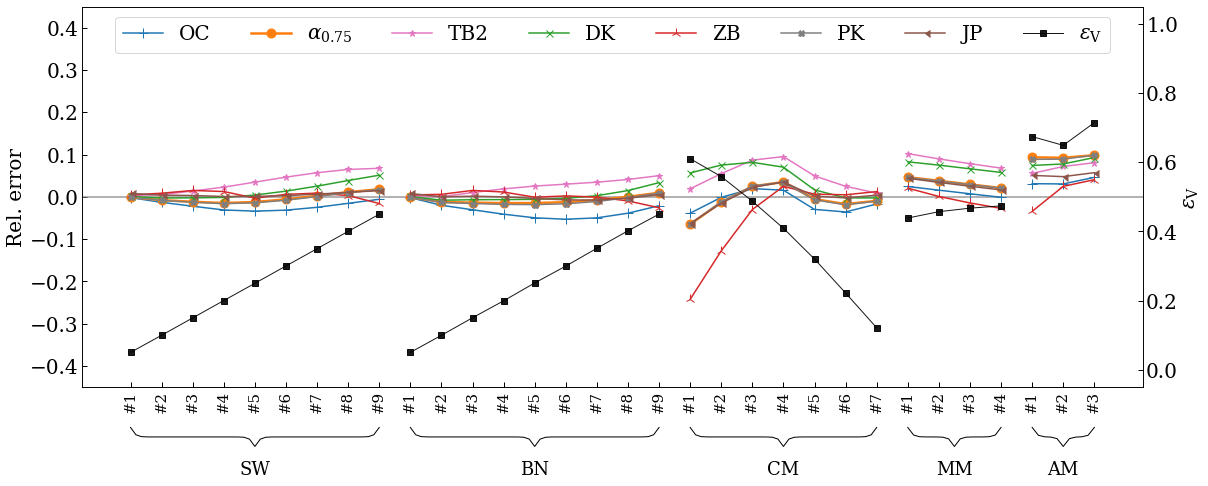

In [40]:
material = 'steel'  # 'steel', 'aluminium', 'spring steel'

fig, ax1 = plt.subplots(figsize=(19,7))
ax2 = ax1.twinx()

x = np.arange(0,spectra_nmbr)
x_ticks_label = []
for key, value in spectra.items():
    if not key == 'BM': 
        x_ticks_label.append([f'#{indx:g}' for indx in np.arange(1, len(value)+1)])
x_ticks_label = [item for sublist in x_ticks_label for item in sublist]

ax1.set_ylabel('Rel. error');
ax2.set_ylabel(r'$\epsilon_\mathrm{V}$')
ax1.set_xticks(x)
ax1.set_xticklabels(x_ticks_label)
#ax1.set_yticks(np.arange(-1,1,.1))
ax2.set_yticks(np.arange(0.,1.1,.2))

ax1.tick_params(axis="y",direction="in", size=5, width=1)
ax1.tick_params(axis="x",direction="in", size=5, width=1, labelbottom=True, rotation=90, labelsize=15)
ax2.tick_params(axis="y",direction="in", size=5, width=1)

ax1.set_ylim(-.45, .45)
ax2.set_ylim(-0.05, 1.05)
ax1.axhline(0, color='grey', alpha=0.8)

method_indx = 0

for  method_key in methods_error[material].keys():

    if method_key in spectral_methods_select[material]:
        
        # set method label
        if method_key == 'A075':
            method_label = r'$\alpha_{0.75}$'
        elif method_key == 'ZB1':
            method_label = 'ZB'
        elif method_key == 'Low':
            method_label = 'Low (2014)'
        else:
            method_label = method_key
        
        method_indx += 1
        x_start = 0
        x_ticks_label = []

        for spectra_group, PSD_key_life in methods_error[material][method_key].items():
            
            # Relative error
            PSD_keys = PSD_key_life.keys() 
            error = PSD_key_life.values() #errors

            # Get vanmarcke parameter
            if method_indx == len(spectral_methods_select[material]):
                vanmarcke_parameters = []
                for PSD_key in PSD_keys:
                    PSD, freq = spectra[spectra_group][PSD_key]
                    sd = FLife.SpectralData((PSD,freq))
                    vanmarcke_parameters.append(sd.get_vanmarcke_parameter(sd.PSD_splitting)[0])

            # spectra group last index
            x_stop = x_start + len(error) # x axis

            # spectra label
            x_ticks_label.append(['#'+str(x_tick_label) for x_tick_label in np.arange(1, len(error)+1)])
            
            if x_start == 0:
                ax1.plot(x[x_start:x_stop], error, label=method_label, **spectral_methods_plot_style[method_key])
                if method_indx == len(spectral_methods_select[material]):
                    ax2.plot(x[x_start:x_stop], vanmarcke_parameters, 's-', color='k', alpha=.9, lw=1, ms=6, label=r'$\epsilon_\mathrm{V}$')
            else:
                ax1.plot(x[x_start:x_stop], error, **spectral_methods_plot_style[method_key])

                if method_indx == len(spectral_methods_select[material]):
                    ax2.plot(x[x_start:x_stop], vanmarcke_parameters, 's-', color='k', alpha=.9, lw=1)
            
            
            if method_indx == len(spectral_methods_select[material]):
                # Spectra group label
                fontdict = dict()
                fontdict['fontsize'] = 18
                fontdict['fontname'] = 'Serif'
                draw_brace(ax2, (x_start,x_stop-1),0.15, spectra_group, fontdict=fontdict)

            # set firtst index for next spectra group
            x_start = x_stop
                        
# 1 legend for 2 axes
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles,labels, loc='upper center', ncol=12);

#plt.savefig('results_steel.pdf', bbox_inches='tight');
#plt.savefig('results_aluminium.pdf', bbox_inches='tight');
#plt.savefig('results_spring_steel.pdf', bbox_inches='tight');

In [41]:
# Plot bimodal methods results
bimodal_methods_error['steel'].keys()

dict_keys(['JM', 'SO', 'FC', 'MFC', 'Low_BM', 'LOW', 'LB', 'HM'])

In [42]:
# BIMODAL methods - select methods that perform best
bimodal_spectral_methods_select =  {}
bimodal_spectral_methods_select['steel'] =  ['JM', 'MFC', 'Low_BM', 'LOW', 'FC']
bimodal_spectral_methods_select['aluminium'] = ['JM', 'MFC', 'LOW', 'HM', 'FC']
bimodal_spectral_methods_select['spring steel'] = ['JM', 'MFC', 'HM', 'FC']


bimodal_spectral_methods_plot_style = dict(
    JM = dict(marker='+', ms=10, linewidth=2.5, color='C0'),
    MFC = dict(marker='o', ms=5, linewidth=2.5, color='C3'),
    Low_BM = dict(marker=5, ms=7, color='C2'),
    LOW = dict(marker='d', ms=7, color='C1'),
    HM = dict(marker=11, color='C4'),
    FC = dict(marker='*', color='C5'),
    LB = dict(marker='d', color='C6'),
)

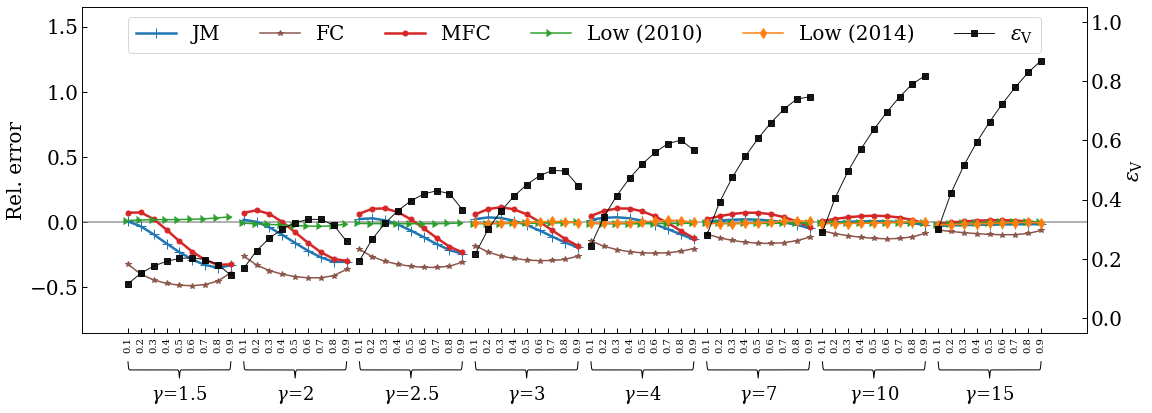

In [43]:
material = 'steel'  # 'steel', 'aluminium', 'spring steel'

fig, ax1 = plt.subplots(figsize=(18,6))
ax2 = ax1.twinx()

x = np.arange(0,bimodal_spectra_nmbr)
x_ticks_label = [f'{var_LF:.1f}' for var_LF in np.arange(0.1, 1, .1)]*8


ax1.set_ylabel('Rel. error');
ax2.set_ylabel(r'$\epsilon_\mathrm{V}$')
ax1.set_xticks(x)
ax1.set_xticklabels(x_ticks_label)
#ax1.set_yticks(np.arange(-1, 1.8,.2))
ax2.set_yticks(np.arange(0.,1.1,.2))

ax1.tick_params(axis="y",direction="in", size=5, width=1)
ax1.tick_params(axis="x",direction="in", size=5, width=1, labelbottom=True, rotation=90, labelsize=10)
ax2.tick_params(axis="y",direction="in", size=5, width=1)

ax1.set_ylim(-.85,1.65)
ax2.set_ylim(-0.05, 1.05)
ax1.axhline(0, color='grey', alpha=0.8)

method_indx = 0

for method_key in bimodal_methods_error[material].keys():

    if method_key in bimodal_spectral_methods_select[material]:
        
        # set method label
        if method_key == 'Low_BM':
            method_label = "Low (2010)"
        elif method_key == 'LOW':
            method_label = 'Low (2014)'
        else:
            method_label = method_key
        
        x_start = 0
        x_ticks_label = []

        ################
        for gamma in gamma_list:

            error_list = []
            keys_list = []
            
            if gamma < 3 and method_key == 'LOW': # Method derived only for gamma>=3
                x_start = 27
                continue
            
            for PSD_key, error in bimodal_methods_error[material][method_key]['BM'].items():
                varLF_key = PSD_key.split('=')[1].split(',')[0]
                
                if float(varLF_key) == gamma:
                    error_list.append(error)
                    keys_list.append(PSD_key)
                    
                    # spectra label
                    x_ticks_label.append(str(varLF_key))
        
            #print(keys_list)
            # Get vanmarcke parameter
            if method_indx == 0:
                vanmarcke_parameters = []
                for PSD_key in keys_list:
                    PSD, freq = spectra['BM'][PSD_key]
                    sd = FLife.SpectralData((PSD,freq))
                    vanmarcke_parameters.append(sd.get_vanmarcke_parameter(sd.PSD_splitting)[0])
        
        
            # spectra group last index
            x_stop = x_start + len(error_list) # x axis

            # spectra label
            #x_ticks_label.append(['#'+str(x_tick_label) for x_tick_label in np.arange(1, len(error_list)+1)])
    
            if x_start == 36:
                ax1.plot(x[x_start:x_stop], error_list, label=method_label, **bimodal_spectral_methods_plot_style[method_key])
                if method_indx == 0:
                    ax2.plot(x[x_start:x_stop], vanmarcke_parameters, 's-', color='k', alpha=.9, lw=1, ms=6, label=r'$\epsilon_\mathrm{V}$')
            else:
                ax1.plot(x[x_start:x_stop], error_list, **bimodal_spectral_methods_plot_style[method_key])

                if method_indx == 0:
                    ax2.plot(x[x_start:x_stop], vanmarcke_parameters, 's-', color='k', alpha=.9, lw=1)
            
            
            if method_indx == 0: # label spectra groups only once
                fontdict = dict()
                fontdict['fontsize'] = 18
                fontdict['fontname'] = 'Serif'
                draw_brace(ax2, (x_start,x_stop-1),0.13, r'$\gamma\!=\!$' + str(gamma), fontdict=fontdict)
                #ax2.text(0.96, -0.05, r'$m_\mathrm{0,LF}/m_0$', transform=ax2.transAxes, size=12, fontname='Serif', fontstyle='normal')
                #ax2.text(-0.02, -0.05, r'$m_\mathrm{0,LF}/m_0$', transform=ax2.transAxes, size=12, fontname='Serif', fontstyle='normal')

            # set first index for next spectra group
            x_start = x_stop
            
        method_indx += 1
            
                        
# 1 legend for 2 axes
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles,labels, loc='upper center', ncol=12);

#plt.savefig('results_steel_bimodal.pdf', bbox_inches='tight');
#plt.savefig('results_aluminium_bimodal.pdf', bbox_inches='tight');
#plt.savefig('results_spring_steel_bimodal.pdf', bbox_inches='tight');